In [1]:
import pickle 
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

from scipy.optimize import minimize
from IPython.display import display, Latex


In [2]:
d2metals = {
    '3': ['Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu'],
    '4': ['Nb', 'Mo', ],
    '5': ['W', ]
}

# for plotting
ele2col = {
    "Ti": "#808080",
    "V": "#ffcccb",
    "Cr": "k",
    "Mn": "#9b870c",
    "Fe": "r",
    "Co": "b",
    "Cu": "#FFFF00",
    "Nb": "cyan",
    "Mo": "#FFA500",
    "Sn": "k",
    "W": "fuchsia",
    "Ir": "b",
    "Ni": "#66FF00",
}

In [3]:
def plot_parabola(parabola):
    x = np.linspace(0, 4, 10)
    y = parabola[0]*x**2+parabola[1]*x
    plt.plot(x, y)
    
def formation_energy_mixing(ele1, ele2, concentrations, plotting=False):
    ox_quadratic_1 = mp_quadratic_equations_ox[ele1]
    ox_quadratic_2 = mp_quadratic_equations_ox[ele2]
    red_quadratic_1 = mp_quadratic_equations_red[ele2]
    red_quadratic_2 = mp_quadratic_equations_red[ele1]

    predicted_forms_1 = []
    predicted_forms_2 = []
    predicted_ox_change_1 = []
    predicted_ox_change_2 = []
    minima = []
    x_tots = []
    for conc in concentrations:
        
        o_1a, o_2a = ox_quadratic_1
        r_1a, r_2a = red_quadratic_1

        o_1b, o_2b = ox_quadratic_2
        r_1b, r_2b = red_quadratic_2
        if plotting:
            #print('checking {}'.format(conc))
            result_1 = minimize(oxidation_reduction_equation, 1, args=(conc, o_1a, o_2a, r_1a, r_2a, True), bounds=[(0, 10)])
            result_2 = minimize(oxidation_reduction_equation, 1, args=(1-conc, o_1b, o_2b, r_1b, r_2b, True), bounds=[(0, 10)])
            
        else:
            result_1 = minimize(oxidation_reduction_equation, 1, args=(conc, o_1a, o_2a, r_1a, r_2a),  bounds=[(0, 10)])
            # Note, the definition of concentration is different  between 1/2,
            # since it relates to the concentration of the element that is 
            # oxidisint or reducing.
            #handle this when plotting by flipping the x-axis horizontally
            result_2 = minimize(oxidation_reduction_equation, 1, args=(1-conc, o_1b, o_2b, r_1b, r_2b),  bounds=[(0, 10)])
        
        x_space = np.linspace(0, 3, 50)
        predicted_ox_change_1.append(result_1.x[0])
        # this can give problems depending on scipy version, might have to use result_1.fun
        predicted_forms_1.append(result_1.fun)
        predicted_ox_change_2.append(result_2.x[0])
        predicted_forms_2.append(result_2.fun)#result_2.fun[0] + diff*(1-conc))
        
        if plotting:
            mixed_1 = o_1a*(x_space**2)*(1-conc)**2+o_2a*x_space*(1-conc)+r_1a*(x_space**2)*conc**2+r_2a*x_space*conc
            ox1 = o_1a*x_space**2+o_2a*x_space
            red1 = r_1a*x_space**2+r_2a*x_space
            mixed_2 = o_1b*(x_space**2)*(conc)**2+o_2b*x_space*(conc)+(r_1b*((1-conc)*x_space)**2+r_2b*(1-conc)*x_space)
            ox2 = o_1b*x_space**2+o_2b*x_space
            red2 = r_1b*x_space**2+r_2b*x_space

            if min(mixed_1)<min(mixed_2):
                minima.append(min(mixed_1))
                x_tots.append(result_1.x[0])
                if conc not in [0, 1]:
                    plt.plot(x_space, mixed_1, label='mixed_{}{:.1f}{}{:.1f}'.format(ele1, 1-conc, ele2, conc), color='gray')
                    plt.plot(result_1.x[0], min(mixed_2), 'bo')
                if conc==0:
                    plt.plot(x_space, ox1, label=ele1+"_ox", color=ele2col[ele1[:-1]])
                    plt.plot(x_space, red1, label=ele2+"_red", color=ele2col[ele2[:-1]])
                if conc==1:
                    plt.legend(fontsize=13)
                    plt.xticks(fontsize=13)
                    plt.yticks(fontsize=13)
                    plt.savefig("{}_{}_mixing.pdf".format(ele1, ele2))
                    plt.show()
            else:
                minima.append(min(mixed_2))
                x_tots.append(result_2.x[0])
                if conc not in [0, 1]:
                    plt.plot(x_space, mixed_2, label='mixed_{}{:.2f}{}{:.2f}'.format(ele1, 1-conc, ele2, conc), )#color='gray')
                    plt.plot(result_2.x[0], min(mixed_2), 'bo')
                if conc==0:
                    plt.plot(x_space, ox2, label=ele2+"_ox", color=ele2col[ele2[:-1]])
                    plt.plot(x_space, red2, label=ele1+"_red", color=ele2col[ele1[:-1]])
                if conc==1:
                    plt.legend(fontsize=13)
                    plt.xticks(fontsize=13)
                    plt.yticks(fontsize=13)
                    plt.legend()
                    plt.savefig("{}_{}_mixing.pdf".format(ele1, ele2))
                    plt.show()
    
    if plotting:
        print("X_tots")
        for x in x_tots:
            print("{:.2f}".format(x), end=", ")
        print("\nΔ Cs")
        for x in minima:
            print("{:.2f}".format(x), end=", ")
        plt.plot(concentrations, minima)
        plt.plot([0, 1], [minima[0], minima[-1]], 'k--')
        plt.legend(fontsize=13)
        plt.xticks([0, 0.25, 0.5, 0.75, 1], fontsize=13)
        plt.yticks(fontsize=13)
        
        plt.savefig("deltaC_1c.pdf")
        plt.show()

        ox2 = o_1b*x_space**2+o_2b*x_space
        red2 = r_1b*x_space**2+r_2b*x_space
        plt.plot(x_space, ox2, label=ele2[:-1], color=ele2col[ele2[:-1]])
        plt.plot(x_space, red2, label=ele1[:-1], color=ele2col[ele1[:-1]])
        plt.ylim(top=1)
        plt.legend(fontsize=13)
        plt.xticks(fontsize=13)
        plt.yticks(fontsize=13)
        plt.savefig("indiv_parabolas_1a.pdf")
        plt.show()
        
    xs_1 = []
    xs_2 = []
    for conc in concentrations:
        # need to shift the energies so that either end is set to 0
        # so shift every point proportionally
        xs_1.append(predicted_forms_1[0]*(1-conc)+predicted_forms_1[-1]*(conc))
        xs_2.append(predicted_forms_2[0]*(1-conc)+predicted_forms_2[-1]*(conc))
        
    return np.array(predicted_forms_1)-xs_1, np.array(predicted_forms_2)-xs_2, predicted_ox_change_1, predicted_ox_change_2

def oxidation_reduction_equation(x, ox_conc, o1, o2, r1, r2, plot=False):
    """
    Defines the equation to optimize oxidation state when mixed
    Args:
    x: The amount of oxidation state change
    ox_conc: The concentration of the oxidising element between 0 and 1
    o1, o2, o3: Define the quadratic equation for the oxidising element
    r1, r2, r3: Define the quadratic equation for the reducing element
    """
    return (o1*x**2*(1-ox_conc)**2+o2*x*(1-ox_conc))+(r1*(ox_conc*x)**2+r2*(ox_conc*x))


def find_nearest(array, value):
    """
    Helper function to find the closest conc
    """
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return idx-1
    else:
        return idx


In [4]:
parabolas = pd.read_csv("supplementary_data/parabola_coeffs.csv", index_col=0)
mp_quadratic_equations_ox = defaultdict()
mp_quadratic_equations_red = defaultdict()

for oxide in parabolas.index:
    if oxide[-1]=="O":
        mp_quadratic_equations_ox[oxide[:-1]+"2"] = (parabolas.loc[oxide][" oxidising a1"], parabolas.loc[oxide][" oxidising a2"])
        mp_quadratic_equations_red[oxide[:-1]+"2"] = (parabolas.loc[oxide][" reducing a1"], parabolas.loc[oxide][" reducing a2"])
    elif oxide[-1]=="3":
        mp_quadratic_equations_ox[oxide[:-3]+"3"] = (parabolas.loc[oxide][" oxidising a1"], parabolas.loc[oxide][" oxidising a2"])
        mp_quadratic_equations_red[oxide[:-3]+"3"] = (parabolas.loc[oxide][" reducing a1"], parabolas.loc[oxide][" reducing a2"])
    
    elif oxide[-1]=="2":
        mp_quadratic_equations_ox[oxide[:-2]+"4"] = (parabolas.loc[oxide][" oxidising a1"], parabolas.loc[oxide][" oxidising a2"])
        mp_quadratic_equations_red[oxide[:-2]+"4"] = (parabolas.loc[oxide][" reducing a1"], parabolas.loc[oxide][" reducing a2"])


In [5]:
binary_pairing_data = pickle.load(open('data_gather/binary_pairing_data.p', 'rb'))

# iterate over these eqs, removing the oxidation number label to get all the elements 
set_of_elements = set([x[:-1] for x in mp_quadratic_equations_ox])
# these give issues in that they cause a bug where the code finds or Ir Yb entries 
# when it shouldn't. I gets mistakenly matched with Ir data, and Y with Yb data.
set_of_elements.remove("I")
set_of_elements.remove("Y")


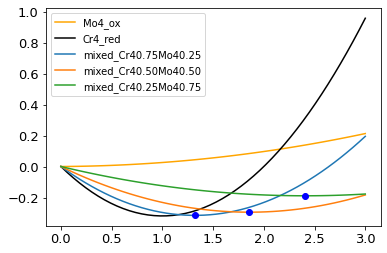

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


X_tots
1.00, 1.32, 1.86, 2.41, 0.00, 
Δ Cs
-0.32, -0.32, -0.29, -0.19, 0.00, 

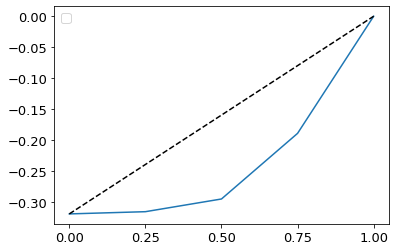

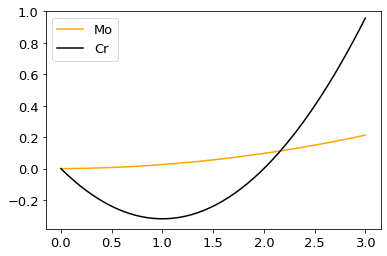

[ 0.         -0.07614592 -0.1353149  -0.10919192  0.        ]


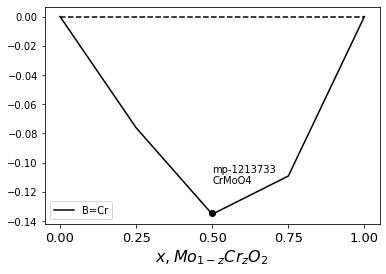

In [6]:
oxidation_state = 4
for housing_element in ['Mo']:
    house_ele_ox = housing_element+str(oxidation_state)
    #print(house_ele_ox)
    if (house_ele_ox not in mp_quadratic_equations_ox.keys() or house_ele_ox not in mp_quadratic_equations_red.keys()):
        print("Missing eq for {}".format(housing_element))
        continue
    
    pairings = []
    ground_states =  []
    zs = [0, 0.25, 0.5, 0.75, 1.0]

    for ele in ['Cr']:

        dope_ele_ox = ele+str(oxidation_state)
        if ele==housing_element:
            continue

        else: 
            pred_1, pred_2, ox_1, ox_2 = formation_energy_mixing(dope_ele_ox, house_ele_ox,
                                                                 zs, plotting=True)

        can_reduce = True
        can_oxidise = True
        # check if it found any solutions 
        if sum(ox_1)==0:
            can_reduce = False
        if sum(ox_2)==0:
            can_oxidise = False 
            
        if can_reduce:
            plt.plot(zs, pred_1, label="B={}".format(ele), color=ele2col[ele])
            plt.plot([zs[0], zs[-1]], [0, 0], 'k--')
            print(pred_1)
        if can_oxidise:
            plt.plot(zs, pred_2, label="B={}".format(ele), ls='-', color=ele2col[ele])#, 'r-')
            plt.plot([zs[0], zs[-1]], [0, 0], 'k--')
            print(pred_2)
        
        if ele<housing_element:
            info_dict = binary_pairing_data[ele+"_"+housing_element+"_"+str(oxidation_state)]
            for match in info_dict:
                if ele in match:
                    conc2plot = float(match.split("_")[1])
                    if info_dict[match]['Coordination match']:
                        plt.plot(conc2plot, info_dict[match]['MP ΔD'], 'o', color=ele2col[ele])
                        plt.text(conc2plot, info_dict[match]['MP ΔD']+0.02, 
                                 info_dict[match]['MP_id']+"\n"+info_dict[match]['MP_name'])

                else:
                    conc2plot = 1-float(match.split("_")[1])
                    if info_dict[match]['Coordination match']:
                        plt.plot(conc2plot, info_dict[match]['MP ΔD'], 'o', color=ele2col[ele])
                        plt.text(conc2plot, info_dict[match]['MP ΔD']+0.02, 
                                 info_dict[match]['MP_id']+"\n"+info_dict[match]['MP_name'])
        else:
            info_dict = binary_pairing_data[housing_element+"_"+ele+"_"+str(oxidation_state)]
            for match in info_dict:
                if ele in match:
                    conc2plot = float(match.split("_")[1])
                    if info_dict[match]['Coordination match']:
                        plt.plot(conc2plot, info_dict[match]['MP ΔD'], 'o', color=ele2col[ele])
                        plt.text(conc2plot, info_dict[match]['MP ΔD']+0.02, 
                                 info_dict[match]['MP_id']+"\n"+info_dict[match]['MP_name'])
                else:
                    conc2plot = 1-float(match.split("_")[1])
                    if info_dict[match]['Coordination match']:
                        plt.plot(conc2plot, info_dict[match]['MP ΔD'], 'o', color=ele2col[ele])
                        plt.text(conc2plot, info_dict[match]['MP ΔD']+0.02, 
                                 info_dict[match]['MP_id']+"\n"+info_dict[match]['MP_name'])
                        
    plt.xticks([0, 0.25, 0.5, 0.75, 1], fontsize=13)
    plt.legend()
    plt.xlabel("$x, {}_{{1-z}}Cr_{{z}}O_{{2}}$".format(housing_element, ), fontsize=16)
    plt.savefig("Cr_Mo_1d.pdf")
        

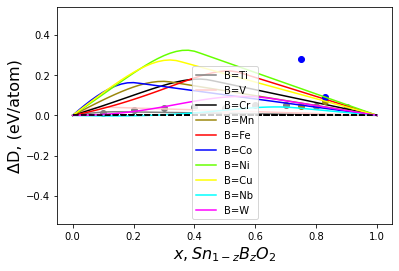

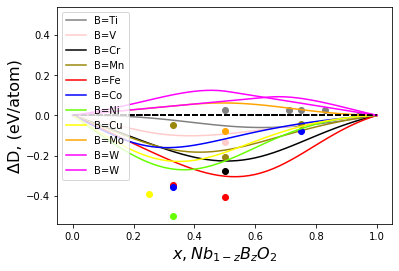

In [7]:
oxidation_state = 4
for housing_element in ['Sn', 'Nb']:
    house_ele_ox = housing_element+str(oxidation_state)
    #print(house_ele_ox)
    if (house_ele_ox not in mp_quadratic_equations_ox.keys() or house_ele_ox not in mp_quadratic_equations_red.keys()):
        print("Missing eq for {}".format(housing_element))
        continue
    
    pairings = []
    ground_states =  []
    zs = np.linspace(0, 1.00, 51)

    for ele in d2metals['3']+d2metals['4']+d2metals['5']:
        #print(ele)
        dope_ele_ox = ele+str(oxidation_state)
        if ele==housing_element:
            continue

        else: 
            pred_1, pred_2, ox_1, ox_2 = formation_energy_mixing(dope_ele_ox, house_ele_ox,
                                                                 zs, )

        can_reduce = True
        can_oxidise = True
        # check if it found any solutions 
        if sum(ox_1)==0:
            can_reduce = False
        if sum(ox_2)==0:
            can_oxidise = False 
            
        if can_reduce:
            plt.plot(zs, pred_1, label="B={}".format(ele), color=ele2col[ele])
            plt.plot([zs[0], zs[-1]], [0, 0], 'k--')
        if can_oxidise:
            plt.plot(zs, pred_2, label="B={}".format(ele), ls='-', color=ele2col[ele])#, 'r-')
            plt.plot([zs[0], zs[-1]], [0, 0], 'k--')
        
        if ele<housing_element:
            info_dict = binary_pairing_data[ele+"_"+housing_element+"_"+str(oxidation_state)]
            for match in info_dict:
                if ele in match:
                    conc2plot = float(match.split("_")[1])
                    if info_dict[match]['Coordination match']:
                        plt.plot(conc2plot, info_dict[match]['MP ΔD'], 'o', color=ele2col[ele])
                else:
                    conc2plot = 1-float(match.split("_")[1])
                    if info_dict[match]['Coordination match']:
                        plt.plot(conc2plot, info_dict[match]['MP ΔD'], 'o', color=ele2col[ele])
        else:
            info_dict = binary_pairing_data[housing_element+"_"+ele+"_"+str(oxidation_state)]
            for match in info_dict:
                if ele in match:
                    conc2plot = float(match.split("_")[1])
                    if info_dict[match]['Coordination match']:
                        plt.plot(conc2plot, info_dict[match]['MP ΔD'], 'o', color=ele2col[ele])
                else:
                    conc2plot = 1-float(match.split("_")[1])
                    if info_dict[match]['Coordination match']:
                        plt.plot(conc2plot, info_dict[match]['MP ΔD'], 'o', color=ele2col[ele])

        
    plt.legend()
    plt.xlabel("$x, {}_{{1-z}}B_{{z}}O_{{2}}$".format(housing_element, ), fontsize=16)
    plt.ylabel("ΔD, (eV/atom)", fontsize=16)
    plt.ylim(-0.54, 0.54)
    plt.savefig("{}_higherdmixing.pdf".format(housing_element))
    plt.show()
        
        

Checking oxides of type as below


<IPython.core.display.Latex object>

Missing eq for Rh
Missing eq for Mo
Missing eq for Tm
Missing eq for Br
Missing eq for Ir
Missing eq for Sb
Missing eq for Ru
Missing eq for Os
Missing eq for Re
Missing eq for Hf
Missing eq for Tc
Missing eq for As
Missing eq for Lu
Missing eq for Au
Missing eq for W
Missing eq for Ge
Missing eq for Se
Missing eq for Dy
Missing eq for Tb
total matches: 596
MAE for unfiltered: 0.208
total matches with good geom: 206
MAE for filtered: 0.124


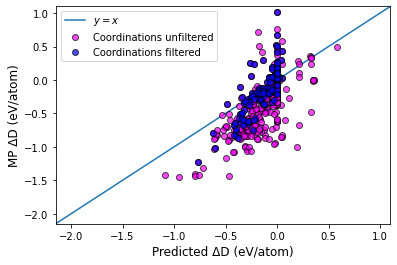

Checking oxides of type as below


<IPython.core.display.Latex object>

Missing eq for Li
Missing eq for Ir
Missing eq for Mg
Missing eq for Hg
Missing eq for K
Missing eq for Ba
Missing eq for Ru
Missing eq for Os
Missing eq for Re
Missing eq for Pt
Missing eq for Zr
Missing eq for Pd
Missing eq for Hf
Missing eq for Tc
Missing eq for Na
Missing eq for Te
Missing eq for Se
Missing eq for Cd
Missing eq for Be
Missing eq for Zn
total matches: 812
MAE for unfiltered: 0.171
total matches with good geom: 134
MAE for filtered: 0.105


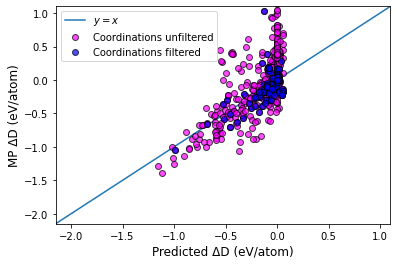

Checking oxides of type as below


<IPython.core.display.Latex object>

Missing eq for Tl
Missing eq for Au
total matches: 919
MAE for unfiltered: 0.122
total matches with good geom: 297
MAE for filtered: 0.095


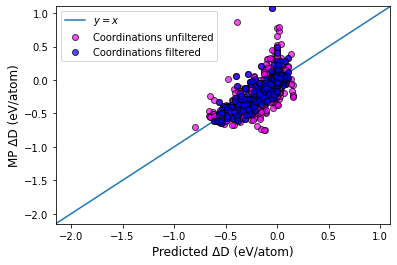

In [8]:
ox2oxide_type = {
    "2": "$A_{1-z}B_{z}O$",
    "3": "$A_{1-z}B_{z}O_{1.5}$",
    "4": "$A_{1-z}B_{z}O_{2}$"
}
maes = []
num_oxides = []

good_maes = []
num_good_oxides = []
# dictionary mapping oxidation state to x/y plot for all oxides 
ox2xs = defaultdict()
ox2ys = defaultdict()
# dictionary mapping oxidation state to x/y plot for oxides conditioned on geometry
ox2good_xs = defaultdict()
ox2good_ys = defaultdict()

# dictionary mapping oxidation state to form ene x/y plot for all oxides 
ox2pred_form_enes = defaultdict()
ox2mp_form_enes = defaultdict()
ox2weighted_avgs = defaultdict()
# dictionary mapping oxidation state to form ene x/y plot for oxides conditioned on geometry
ox2good_pred_form_enes = defaultdict()
ox2good_mp_form_enes = defaultdict()
ox2good_weighted_avgs = defaultdict()


for oxidation_state in [2, 3, 4]:
    print("Checking oxides of type as below")
    display(Latex(ox2oxide_type[str(oxidation_state)]))
    data_dict = defaultdict()
    seen_combinations = []
    lower_lim = -2.15
    upper_lim = 1.1
    for housing_element in set_of_elements:
        house_ele_ox = housing_element+str(oxidation_state)
        if (house_ele_ox not in mp_quadratic_equations_ox.keys() or house_ele_ox not in mp_quadratic_equations_red.keys()):
            print("Missing eq for {}".format(housing_element))
            continue

        pairings = []
        ground_states =  []
        zs = np.linspace(0, 1.00, 51)

        for ele in set_of_elements:
            dope_ele_ox = ele+str(oxidation_state)
            if housing_element+ele in seen_combinations or ele+housing_element in seen_combinations or ele==housing_element:
                continue
            else:
                seen_combinations.append(ele+housing_element)
            if ele<housing_element:
                info_dict = binary_pairing_data[ele+"_"+housing_element+"_"+str(int(oxidation_state))]
            else:
                info_dict = binary_pairing_data[housing_element+"_"+ele+"_"+str(int(oxidation_state))]
            if len(info_dict)==0:
                continue
            if dope_ele_ox not in mp_quadratic_equations_ox.keys() or house_ele_ox not in mp_quadratic_equations_ox.keys():
                continue

            pred_1, pred_2, ox_1, ox_2 = formation_energy_mixing(dope_ele_ox, house_ele_ox,
                                                                 zs, )
            for ele_conc in info_dict:
                conc = float(ele_conc.split("_")[1])
                #closest_idx = find_nearest(zs, conc)
                if ele+"_{:.2f}".format(conc)==ele_conc:# in info_dict.keys():
                    # the 'element' variable is the one with that conc
                    # the ele conc is the one we get a ΔD value for at 
                    # given conc, and this has to match the way
                    # the weighted average was calculated
                    # this key will be accessed later
                    inner_key = ele+housing_element+"{:.2f}".format(conc)
                    closest_idx = find_nearest(zs, conc)

                elif housing_element+"_{:.2f}".format(conc)==ele_conc:
                    # the 'housing_element' is the one with that conc
                    inner_key = housing_element+ele+"{:.2f}".format(conc)
                    # since the ΔD is calculated for ele conc, need to switch 
                    # to the other side of the diagram
                    closest_idx = find_nearest(zs, 1-conc)
                    
                if pred_2[closest_idx]<pred_1[closest_idx]:
                    ox_change = ox_2[closest_idx]
                else:
                    ox_change = ox_1[closest_idx]

                data_dict[inner_key] = {
                    "predicted ΔD": min(pred_2[closest_idx], pred_1[closest_idx]),
                    "true ΔD": info_dict[ele_conc]['MP ΔD'],
                    "predicted formation energy": min(pred_2[closest_idx], pred_1[closest_idx]) + info_dict[ele_conc]['MP weighted average'],
                    "true formation energy": info_dict[ele_conc]['MP weighted average']+info_dict[ele_conc]['MP ΔD'],
                    "weighted average of refs": info_dict[ele_conc]['MP weighted average'],
                    "coordination_match": info_dict[ele_conc]['Coordination match'],
                    "x_tot": ox_change,
                    "mp_id": info_dict[ele_conc]['MP_id'],
                    "mp_name": info_dict[ele_conc]['MP_name'],
                    "motifs": info_dict[ele_conc]['motifs'],
                }
                
    plt.plot([lower_lim, upper_lim], [lower_lim, upper_lim], label='$y=x$')
    xs = []
    ys = []
    pred_form_enes = []
    mp_form_enes = []
    weighted_avgs = []
    for key, val in data_dict.items():
        xs.append(val['predicted ΔD'])
        ys.append(val['true ΔD'])
        
        pred_form_enes.append(val['predicted formation energy'])
        mp_form_enes.append(val['true formation energy'])
        weighted_avgs.append(val['weighted average of refs'])
    print("total matches: {}".format(len(xs)))
    plt.plot(xs, ys, 'o', color='fuchsia', alpha=0.7, label='Coordinations unfiltered', markeredgecolor='k')
    print("MAE for unfiltered: {:.3f}".format(np.mean(abs(np.array(xs)-np.array(ys)))))
    plt.xlabel("Predicted ΔD (eV/atom)", fontsize=12)
    plt.ylabel("MP ΔD (eV/atom)", fontsize=12)
    maes.append(np.mean(abs(np.array(xs)-np.array(ys))))
    num_oxides.append(len(xs))
    ox2xs[oxidation_state] = xs
    ox2ys[oxidation_state] = ys
    ox2pred_form_enes[oxidation_state] = pred_form_enes
    ox2mp_form_enes[oxidation_state] = mp_form_enes
    ox2weighted_avgs[oxidation_state] = weighted_avgs

    xs = []
    ys = []
    pred_form_enes = []
    mp_form_enes = []
    weighted_avgs = []
    for key, val in data_dict.items():
        if not val['coordination_match']:
            # bad geometry, skip
            continue
        xs.append(val['predicted ΔD'])
        ys.append(val['true ΔD'])
        
        pred_form_enes.append(val['predicted formation energy'])
        mp_form_enes.append(val['true formation energy'])
        weighted_avgs.append(val['weighted average of refs'])
#         if abs(xs[-1]-ys[-1])>0.5:
#             plt.text(xs[-1], ys[-1], "{}".format(key))

    ox2good_xs[oxidation_state] = xs
    ox2good_ys[oxidation_state] = ys
    ox2good_pred_form_enes[oxidation_state] = pred_form_enes
    ox2good_mp_form_enes[oxidation_state] = mp_form_enes
    ox2good_weighted_avgs[oxidation_state] = weighted_avgs
    print("total matches with good geom: {}".format(len(xs)))
    plt.plot(xs, ys, 'o', color='b', alpha=0.7, label='Coordinations filtered', markeredgecolor='k')
    print("MAE for filtered: {:.3f}".format(np.mean(abs(np.array(xs)-np.array(ys)))))
    plt.xlim(lower_lim, upper_lim)
    plt.ylim(lower_lim, upper_lim)
    plt.legend()
    plt.xlabel("Predicted ΔD (eV/atom)", fontsize=12)
    plt.ylabel("MP ΔD (eV/atom)", fontsize=12)
    plt.savefig("parities_ox_state_{}.pdf".format(oxidation_state))
    plt.show()
    good_maes.append(np.mean(abs(np.array(xs)-np.array(ys))))
    num_good_oxides.append(len(xs))


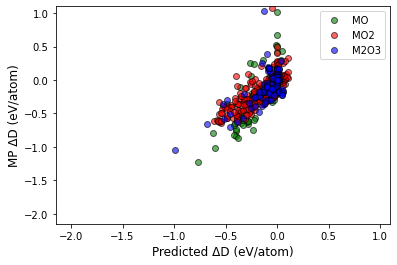

In [9]:
plt.plot(ox2good_xs[2], ox2good_ys[2], 'o', color='g', alpha=0.6, label='MO', markeredgecolor='k')
plt.plot(ox2good_xs[4], ox2good_ys[4], 'o', color='r', alpha=0.6, label='MO2', markeredgecolor='k')
plt.plot(ox2good_xs[3], ox2good_ys[3], 'o', color='b', alpha=0.6, label='M2O3', markeredgecolor='k')
plt.xlim(lower_lim, upper_lim)
plt.ylim(lower_lim, upper_lim)
plt.legend()
plt.xlabel("Predicted ΔD (eV/atom)", fontsize=12)
plt.ylabel("MP ΔD (eV/atom)", fontsize=12)
plt.savefig("parity_filtered_all.pdf")


Text(0, 0.5, 'MP Δ$E_{f}$ (eV/atom)')

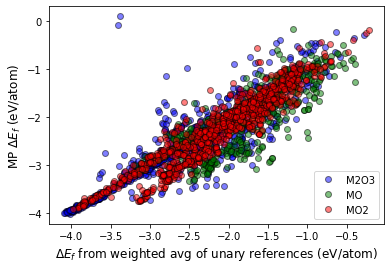

In [10]:
plt.plot(ox2weighted_avgs[3], ox2mp_form_enes[3], 'o', color='b', alpha=0.5, label='M2O3', markeredgecolor='k')
plt.plot(ox2weighted_avgs[2], ox2mp_form_enes[2], 'o', color='g', alpha=0.5, label='MO', markeredgecolor='k')
plt.plot(ox2weighted_avgs[4], ox2mp_form_enes[4], 'o', color='r', alpha=0.5, label='MO2', markeredgecolor='k')
#plt.xlim(-4.2, 0.6)
#plt.ylim(-4.2, 0.6)
plt.legend()
plt.xlabel("Δ$E_{f}$ from weighted avg of unary references (eV/atom)", fontsize=12)
plt.ylabel("MP Δ$E_{f}$ (eV/atom)", fontsize=12)
#plt.savefig("parity_form_ene_no_filter.pdf")

Text(0, 0.5, 'MP Δ$E_{f}$ (eV/atom)')

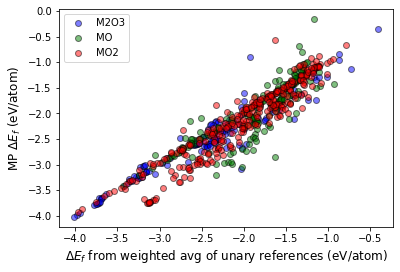

In [11]:
plt.plot(ox2good_weighted_avgs[3], ox2good_mp_form_enes[3], 'o', color='b', alpha=0.5, label='M2O3', markeredgecolor='k')
plt.plot(ox2good_weighted_avgs[2], ox2good_mp_form_enes[2], 'o', color='g', alpha=0.5, label='MO', markeredgecolor='k')
plt.plot(ox2good_weighted_avgs[4], ox2good_mp_form_enes[4], 'o', color='r', alpha=0.5, label='MO2', markeredgecolor='k')
#plt.xlim(-4.2, 0.6)
#plt.ylim(-4.2, 0.6)
plt.legend()
plt.xlabel("Δ$E_{f}$ from weighted avg of unary references (eV/atom)", fontsize=12)
plt.ylabel("MP Δ$E_{f}$ (eV/atom)", fontsize=12)
#plt.savefig("parity_form_ene_no_filter.pdf")

MAE for M2O3: 0.171
MAE for MO: 0.208
MAE for MO2: 0.122


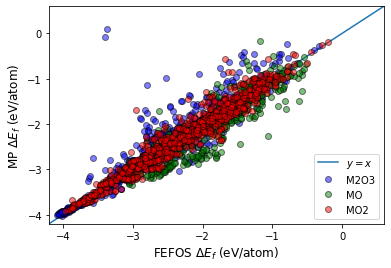

In [12]:
plt.plot([-4.2, 0.6], [-4.2, 0.6], label='$y=x$')
plt.plot(ox2pred_form_enes[3], ox2mp_form_enes[3], 'o', color='b', alpha=0.5, label='M2O3', markeredgecolor='k')
print("MAE for M2O3: {:.3f}".format(np.mean(abs(np.array(ox2pred_form_enes[3])-np.array(ox2mp_form_enes[3])))))
plt.plot(ox2pred_form_enes[2], ox2mp_form_enes[2], 'o', color='g', alpha=0.5, label='MO', markeredgecolor='k')
print("MAE for MO: {:.3f}".format(np.mean(abs(np.array(ox2pred_form_enes[2])-np.array(ox2mp_form_enes[2])))))
plt.plot(ox2pred_form_enes[4], ox2mp_form_enes[4], 'o', color='r', alpha=0.5, label='MO2', markeredgecolor='k')
print("MAE for MO2: {:.3f}".format(np.mean(abs(np.array(ox2pred_form_enes[4])-np.array(ox2mp_form_enes[4])))))
plt.xlim(-4.2, 0.6)
plt.ylim(-4.2, 0.6)
plt.legend()
plt.xlabel("FEFOS Δ$E_{f}$ (eV/atom)", fontsize=12)
plt.ylabel("MP Δ$E_{f}$ (eV/atom)", fontsize=12)
plt.savefig("parity_form_ene_no_filter.pdf")

MAE for M2O3-type: 0.105


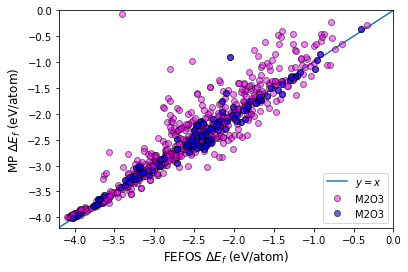

In [17]:
plt.plot([-4.2, 0.6], [-4.2, 0.6], label='$y=x$')
plt.plot(ox2pred_form_enes[3], ox2mp_form_enes[3], 'o', color='fuchsia', alpha=0.5, label='M2O3', markeredgecolor='k')
plt.plot(ox2good_pred_form_enes[3], ox2good_mp_form_enes[3], 'o', color='b', alpha=0.6, label='M2O3', markeredgecolor='k')
print("MAE for M2O3-type: {:.3f}".format(np.mean(abs(np.array(ox2good_pred_form_enes[3])-np.array(ox2good_mp_form_enes[3])))))
plt.xlim(-4.2, 0.)
plt.ylim(-4.2, 0)
plt.legend()
plt.xlabel("FEFOS Δ$E_{f}$ (eV/atom)", fontsize=12)
plt.ylabel("MP Δ$E_{f}$ (eV/atom)", fontsize=12)
plt.savefig("parity_form_ene_m2o3.pdf")


MAE for MO-type: 0.124
MAE for MO2-type: 0.095
MAE for M2O3-type: 0.105


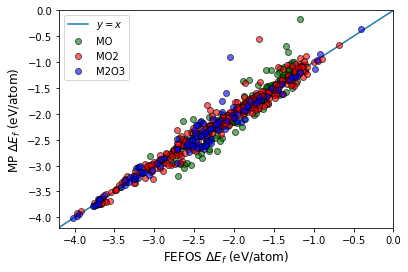

In [13]:
plt.plot([-4.2, 0.6], [-4.2, 0.6], label='$y=x$')
plt.plot(ox2good_pred_form_enes[2], ox2good_mp_form_enes[2], 'o', color='g', alpha=0.6, label='MO', markeredgecolor='k')
print("MAE for MO-type: {:.3f}".format(np.mean(abs(np.array(ox2good_pred_form_enes[2])-np.array(ox2good_mp_form_enes[2])))))
plt.plot(ox2good_pred_form_enes[4], ox2good_mp_form_enes[4], 'o', color='r', alpha=0.6, label='MO2', markeredgecolor='k')
print("MAE for MO2-type: {:.3f}".format(np.mean(abs(np.array(ox2good_pred_form_enes[4])-np.array(ox2good_mp_form_enes[4])))))
plt.plot(ox2good_pred_form_enes[3], ox2good_mp_form_enes[3], 'o', color='b', alpha=0.6, label='M2O3', markeredgecolor='k')
print("MAE for M2O3-type: {:.3f}".format(np.mean(abs(np.array(ox2good_pred_form_enes[3])-np.array(ox2good_mp_form_enes[3])))))
plt.xlim(-4.2, 0.0)
plt.ylim(-4.2, 0.0)
plt.legend()
plt.xlabel("FEFOS Δ$E_{f}$ (eV/atom)", fontsize=12)
plt.ylabel("MP Δ$E_{f}$ (eV/atom)", fontsize=12)
plt.savefig("parity_form_ene_filter.pdf")


In [14]:
total_oxides = sum(num_oxides)
unfiltered_avg = 0
for num_ox, mae in zip(num_oxides, maes):
    unfiltered_avg+=num_ox*mae*(1.0/total_oxides)
print("Total MAE for unfiltered: {:.3f} eV/atom".format(unfiltered_avg))
total_oxides = sum(num_good_oxides)
filtered_avg = 0
for num_ox, mae in zip(num_good_oxides, good_maes):
    filtered_avg+=num_ox*mae*(1.0/total_oxides)
print("Total MAE for filtered: {:.3f} eV/atom".format(filtered_avg))


Total MAE for unfiltered: 0.161 eV/atom
Total MAE for filtered: 0.107 eV/atom


### Saving for spreadsheet

In [15]:
ox2oxide_type = {
    "2": "$A_{1-z}B_{z}O$",
    "3": "$A_{1-z}B_{z}O_{1.5}$",
    "4": "$A_{1-z}B_{z}O_{2}$"
}
with open("fefos_predictions.csv", "w") as f:
    f.write("oxide,mp-id,mp formation energy,pred form ene,true Delta(D),prediction Delta(D),weighted avg of refs,x_tot,coordination_match,coordination_motifs\n")
    for oxidation_state in [2, 3, 4]:
        print("Checking oxides of type as below")
        display(Latex(ox2oxide_type[str(oxidation_state)]))
        data_dict = defaultdict()
        seen_combinations = []

        for housing_element in sorted(set_of_elements):
            house_ele_ox = housing_element+str(oxidation_state)
            if (house_ele_ox not in mp_quadratic_equations_ox.keys() or house_ele_ox not in mp_quadratic_equations_red.keys()):
                print("Missing eq for {}".format(housing_element))
                continue

            pairings = []
            ground_states =  []
            zs = np.linspace(0, 1.00, 51)

            for ele in sorted(set_of_elements):
                dope_ele_ox = ele+str(oxidation_state)
                if housing_element+ele in seen_combinations or ele+housing_element in seen_combinations or ele==housing_element:
                    continue
                else:
                    seen_combinations.append(ele+housing_element)
                if ele<housing_element:
                    info_dict = binary_pairing_data[ele+"_"+housing_element+"_"+str(int(oxidation_state))]
                else:
                    info_dict = binary_pairing_data[housing_element+"_"+ele+"_"+str(int(oxidation_state))]
                if len(info_dict)==0:
                    continue
                if dope_ele_ox not in mp_quadratic_equations_ox.keys() or house_ele_ox not in mp_quadratic_equations_ox.keys():
                    continue
                pred_1, pred_2, ox_1, ox_2 = formation_energy_mixing(dope_ele_ox, house_ele_ox,
                                                                     zs, )
                for ele_conc in info_dict:
                    conc = float(ele_conc.split("_")[1])
                    #closest_idx = find_nearest(zs, conc)
                    if ele+"_{:.2f}".format(conc)==ele_conc:# in info_dict.keys():
                        # the 'element' variable is the one with that conc
                        # the ele conc is the one we get a ΔD value for at 
                        # given conc, and this has to match the way
                        # the weighted average was calculated
                        # this key will be accessed later
                        inner_key = ele+housing_element+"{:.2f}".format(conc)
                        closest_idx = find_nearest(zs, conc)

                    elif housing_element+"_{:.2f}".format(conc)==ele_conc:
                        # the 'housing_element' is the one with that conc
                        inner_key = housing_element+ele+"{:.2f}".format(conc)
                        # since the ΔD is calculated for ele conc, need to switch 
                        # to the other side of the diagram
                        closest_idx = find_nearest(zs, 1-conc)

                    if pred_2[closest_idx]<pred_1[closest_idx]:
                        ox_change = ox_2[closest_idx]
                    else:
                        ox_change = ox_1[closest_idx]

                    data_dict[inner_key] = {
                        "predicted ΔD": min(pred_2[closest_idx], pred_1[closest_idx]),
                        "true ΔD": info_dict[ele_conc]['MP ΔD'],
                        "predicted formation energy": min(pred_2[closest_idx], pred_1[closest_idx]) + info_dict[ele_conc]['MP weighted average'],
                        "true formation energy": info_dict[ele_conc]['MP weighted average']+info_dict[ele_conc]['MP ΔD'],
                        "weighted average of refs": info_dict[ele_conc]['MP weighted average'],
                        "coordination_match": info_dict[ele_conc]['Coordination match'],
                        "x_tot": ox_change,
                        "mp_id": info_dict[ele_conc]['MP_id'],
                        "mp_name": info_dict[ele_conc]['MP_name'],
                        "motifs": info_dict[ele_conc]['motifs'],
                    }
                    line = data_dict[inner_key]['mp_name'] + ","
                    line += data_dict[inner_key]['mp_id'] + ","
                    line += "{:.4f}".format(data_dict[inner_key]['true formation energy']) + ","
                    line += "{:.4f}".format(data_dict[inner_key]['predicted formation energy']) + ","
                    line += "{:.4f}".format(data_dict[inner_key]['true ΔD']) + ","
                    line += "{:.4f}".format(data_dict[inner_key]['predicted ΔD']) + ","
                    line += "{:.4f}".format(data_dict[inner_key]['weighted average of refs']) + ","
                    line += "{:.4f}".format(data_dict[inner_key]['x_tot']) + ","
                    line += "{:.4f}".format(data_dict[inner_key]['coordination_match']) + ","
                    motifs2print = ""
                    for motif in data_dict[inner_key]['motifs']:
                        motifs2print+=motif+"/"
                    motifs2print = motifs2print[:-1]
                    line += motifs2print
                    f.write(line+"\n")




Checking oxides of type as below


<IPython.core.display.Latex object>

Missing eq for As
Missing eq for Au
Missing eq for Br
Missing eq for Dy
Missing eq for Ge
Missing eq for Hf
Missing eq for Ir
Missing eq for Lu
Missing eq for Mo
Missing eq for Os
Missing eq for Re
Missing eq for Rh
Missing eq for Ru
Missing eq for Sb
Missing eq for Se
Missing eq for Tb
Missing eq for Tc
Missing eq for Tm
Missing eq for W
Checking oxides of type as below


<IPython.core.display.Latex object>

Missing eq for Ba
Missing eq for Be
Missing eq for Cd
Missing eq for Hf
Missing eq for Hg
Missing eq for Ir
Missing eq for K
Missing eq for Li
Missing eq for Mg
Missing eq for Na
Missing eq for Os
Missing eq for Pd
Missing eq for Pt
Missing eq for Re
Missing eq for Ru
Missing eq for Se
Missing eq for Tc
Missing eq for Te
Missing eq for Zn
Missing eq for Zr
Checking oxides of type as below


<IPython.core.display.Latex object>

Missing eq for Au
Missing eq for Tl
